In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/Tesis/Desarrollo/"
print(root_dir)

Mounted at /content/drive
/content/drive/My Drive/Tesis/Desarrollo/


In [ ]:
base_dir = root_dir + 'ColeccionGrande/'
print(base_dir)

/content/drive/My Drive/Tesis/Desarrollo/ColeccionGrande/


In [ ]:
import h5py
import numpy as np
hf = h5py.File(base_dir + 'Datasets256.hdf5', 'r')

In [ ]:
img = np.array(hf.get('S_train')[0])

In [ ]:
img.shape

(256, 256, 4)

## **Importar datasets ya construídos:**

In [ ]:
import h5py
import numpy as np
hf = h5py.File(base_dir + 'Datasets256.hdf5', 'r')

S_train = np.array(hf.get('S_train')[0:2500])
print('S_train cargado.')
S_test = np.array(hf.get('S_test')[0:650])
print('S_test cargado.')
P_train = np.array(hf.get('P_train')[0:2500])
print('P_train cargado.')
P_test = np.array(hf.get('P_test')[0:650])
print('P_test cargado.')

print(S_train.shape, S_test.shape, P_train.shape, P_test.shape)

S_train cargado.
S_test cargado.
P_train cargado.
P_test cargado.
(2500, 256, 256, 4) (650, 256, 256, 4) (2500, 256, 256) (650, 256, 256)


In [ ]:
P_train = P_train.reshape((-1, 256, 256, 1))
P_test = P_test.reshape((-1, 256, 256, 1))

In [ ]:
print(S_train.shape, S_test.shape, P_train.shape, P_test.shape)

(2500, 256, 256, 4) (650, 256, 256, 4) (2500, 256, 256, 1) (650, 256, 256, 1)


## **Construcción de la red neuronal tipo UNET**

**Una vez se tienen las entradas(S) y salidas(P) definidas, se realiza el diseño de una arquitectura de red neuronal por medio de Tensorflow:**

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import concatenate
from keras.layers import UpSampling2D
from keras.layers import Input, Dropout
from tensorflow.keras import Model

In [3]:
from keras.layers import Activation, BatchNormalization, Conv2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.layers import MaxPooling2D, Dropout, Input, AveragePooling2D, Reshape, Permute, UpSampling2D
from keras.layers import SimpleRNN, Bidirectional, LSTM
from keras.layers import Lambda
from keras.models import load_model, Model
from keras.losses import sparse_categorical_crossentropy
import tensorflow as tf

from keras.optimizers import *
import keras.backend as K
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
def get_model8():
    ## input to the network
    input = Input((256, 256, 4))

    ## encoder network
    c1 = Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(input)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = AveragePooling2D()(c1)

    c2 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = AveragePooling2D()(c2)

    c3 = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = AveragePooling2D()(c3)

    c4 = Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = AveragePooling2D()(c4)

    # SQD-LSTM Block
    x_hor_1 = Reshape((16 * 16, 128))(p4)
    x_ver_1 = Reshape((16 * 16, 128))(Permute((2, 1, 3))(p4))

    h_hor_1 = Bidirectional(LSTM(units=32, activation='tanh', return_sequences=True, go_backwards=False))(x_hor_1)
    h_ver_1 = Bidirectional(LSTM(units=32, activation='tanh', return_sequences=True, go_backwards=False))(x_ver_1)

    H_hor_1 = Reshape((16, 16, 64))(h_hor_1)
    H_ver_1 = Permute((2, 1, 3))(Reshape((16, 16, 64))(h_ver_1))

    c_hor_1 = Conv2D(filters=64, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_hor_1)
    c_ver_1 = Conv2D(filters=64, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_ver_1)

    H = concatenate([c_hor_1, c_ver_1])

    # decoder Network
    u5 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(H)
    u5 = concatenate([u5, c4])
    c5 = Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    u6 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

    u7 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u8 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    ## output layer
    output = Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='out1')(c8)
    output = Activation('linear')(output)

    model = Model(inputs=[input], outputs=[output])
    return model

In [6]:
from tensorflow.keras.optimizers import Adam
model = get_model8()

model_id = 'Model8_100e_4b_256_2500'
model_path = '/content/drive/My Drive/Tesis/Desarrollo/Modelos/{}.h5'.format(model_id)

loss = "mean_squared_error"

model.compile(optimizer="adam", loss = loss)

earlystopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  592         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
history = model.fit(S_train, P_train, validation_data=(S_test, P_test), epochs=100, batch_size=4, callbacks=[model_checkpoint, earlystopper])

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 0.0342
Epoch 1: val_loss improved from inf to 0.00928, saving model to /content/drive/My Drive/Tesis/Desarrollo/Modelos/Model8_100e_4b_256_2500.h5
625/625 [==============================] - 60s 68ms/step - loss: 0.0342 - val_loss: 0.0093
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 0.0083
Epoch 2: val_loss did not improve from 0.00928
625/625 [==============================] - 38s 61ms/step - loss: 0.0083 - val_loss: 0.0107
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 0.0071
Epoch 3: val_loss improved from 0.00928 to 0.00565, saving model to /content/drive/My Drive/Tesis/Desarrollo/Modelos/Model8_100e_4b_256_2500.h5
625/625 [==============================] - 39s 62ms/step - loss: 0.0071 - val_loss: 0.0056
Epoch 4/100
625/625 [==============================] - ETA: 0s - loss: 0.0058
Epoch 4: val_loss did not improve from 0.00565
625/625 [============================

## **Funciones para mostrar resultados**

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def loss_plot(history):
  loss = history.history['loss']
  epochs = np.arange(0, len(loss), 1)
  plt.plot(epochs, loss)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Epochs vs. Loss")
  plt.yscale("log")
  plt.grid()
  plt.show

In [ ]:
def overf_plot(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss vs. epochs')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.yscale("log")
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
def plot(*argv, titles=None):
  """
  plots a given number of phase maps
  """
  if len(argv) == 1:
    f, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 5))
    if titles is not None:
      ax.set_title(titles)
    a = ax.imshow(argv[0].squeeze(), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    f.colorbar(a, cax=cax)
    plt.show()
  else:
    f, axes = plt.subplots(1, len(argv), sharey=True, figsize=(10, 10))
    for i in range(len(argv)):
        if titles is not None:
          axes[i].set_title(titles[i])
        a = axes[i].imshow(argv[i].squeeze(), cmap='gray')
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        f.colorbar(a, cax=cax)
    plt.show()
    f.colorbar(a, cax=cax)

In [ ]:
def plot_hist(*argv, titles):
  """
  plots the historgram of the input phase maps
  """
  for i in range(len(argv)):
      hist = np.histogram(argv[i].ravel(), bins=100)
      plt.plot(hist[1][1:], hist[0])
  plt.xlabel("phase values")
  plt.ylabel("frequency")
  plt.title("Histogram Analysis")
  plt.grid()
  if titles is not None:
    plt.legend(titles)
  plt.show()

In [ ]:
def read_model(model, url, bs):
  model = model
  model.compile(optimizer="adam", loss = 'mean_squared_error')

  model_path = '/content/drive/My Drive/Tesis/Desarrollo/Modelos/Unet8/' + url
  model.load_weights(model_path)
  return model


In [ ]:
def show_results(model, url, bs):
  model = read_model(model, url, bs)
  y_pred = model.predict(S_test, batch_size=bs)
  idx = np.random.randint(0, S_test.shape[0])
  print(idx)

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
  ax1.imshow(S_test[idx], cmap = 'jet')
  ax1.set_title('Imagen 4-stack')
  ax2.imshow(P_test[idx].reshape(256, 256), cmap = 'gray')
  ax2.set_title('Resultado esperado')
  ax3.imshow(y_pred[idx].reshape(256, 256), cmap = 'gray')
  ax3.set_title('Resultado obtenido')

In [ ]:
## visualize
def visualize():
  y_pred = model.predict(S_test, batch_size=4)
  y_pred_scaled = np.empty((0, 256, 256))
  for i in range(10):
    Xi = S_test[i]
    yi = P_test[i]
    ypi = y_pred[i]

    # match scales of predicted true phase
    min1, max1 = np.min(yi), np.max(yi)
    min2, max2 = np.min(ypi), np.max(ypi)
    temp = (ypi - min2) / (max2 - min2)
    ypi_scaled = temp * (max1 - min1) + min1
    y_pred_scaled = np.vstack((y_pred_scaled, ypi_scaled.reshape(1, 256, 256)))

    # visualize
    plot(Xi, yi, ypi_scaled, titles=["Noisy Wrapped Phase ($\psi$)", "True Phase ($\phi$)", "Predicted True Phase ($\hat{\phi}$)"])
    plot_hist(yi, ypi_scaled, titles=["True Phase ($\phi$)", "Predicted True Phase ($\hat{\phi}$)"])

## **Resultados de los modelos generados**

**Model8_100e_4b_256_2500**

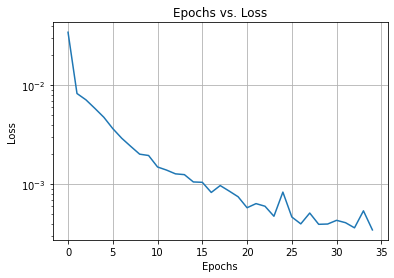

In [ ]:
loss_plot(history)

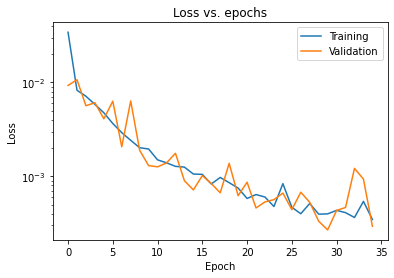

In [ ]:
overf_plot(history)

390


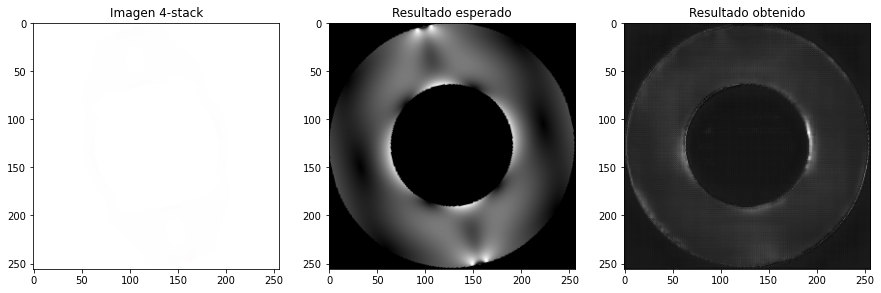

In [ ]:
show_results(get_model8(), 'Model8_100e_4b_256_2500.h5', 4)

40


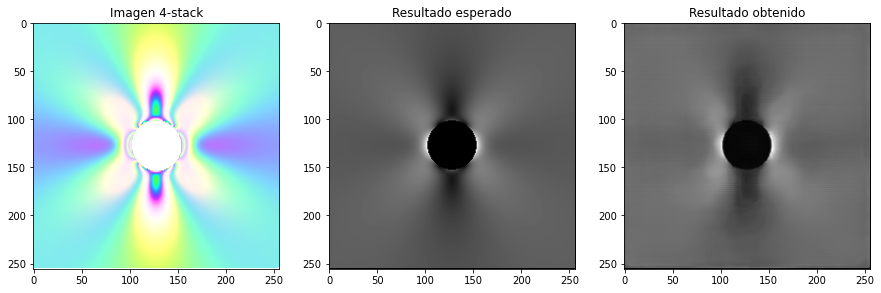

In [ ]:
show_results(get_model8(), 'Model8_100e_4b_256_2500.h5', 4)

456


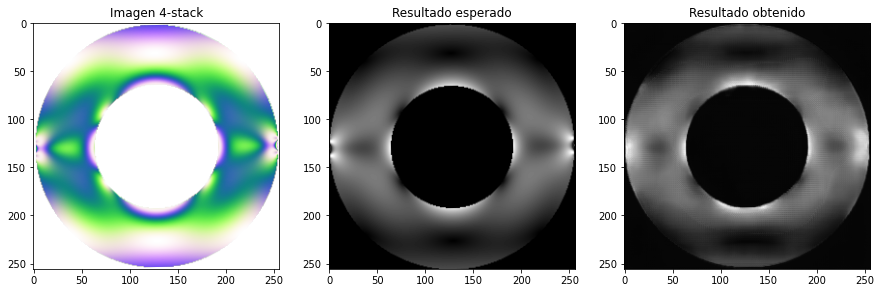

In [ ]:
show_results(get_model8(), 'Model8_100e_4b_256_2500.h5', 4)

226


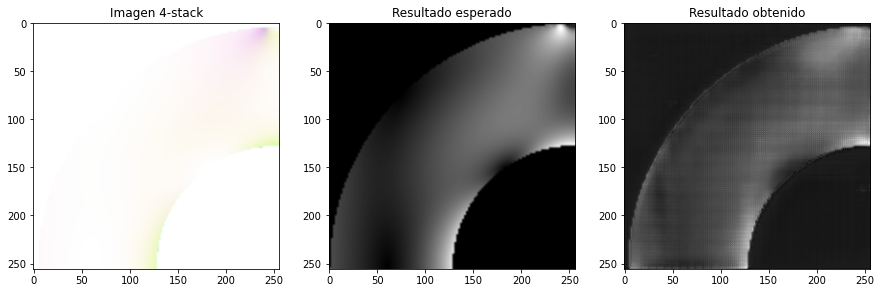

In [ ]:
show_results(get_model8(), 'Model8_100e_4b_256_2500.h5', 4)

---

## **Métricas MSE, SSIM y PSNR Promedio por modelo**

#### **Función de cómputo de métricas**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

def metrics(model, url, bs):
  model = read_model(model, url, bs)
  y_pred = model.predict(S_test, batch_size=bs)
  mse_array = np.array([])
  ssim_array = np.array([])
  psnr_array = np.array([])

  for i in range(S_test.shape[0]):
    exp = P_test[i][:,:,0]
    pred = y_pred[i][:,:,0]
    mse_res = mse(exp, pred)
    ssim_res = ssim(exp, pred, data_range=pred.max() - pred.min())
    psnr_res = psnr(exp, pred, data_range=pred.max() - pred.min())

    mse_array = np.append(mse_array, mse_res)
    ssim_array = np.append(ssim_array, ssim_res)
    psnr_array = np.append(psnr_array, psnr_res)

  print('Mean MSE: ' + repr(mse_array.mean()))
  print('Mean SSIM: ' + repr(ssim_array.mean()))
  print('Mean PSNR: ' + repr(psnr_array.mean()))
  print('Std. Dev MSE: ' + repr(mse_array.std()))
  print('Std. Dev SSIM: ' + repr(ssim_array.std()))
  print('Std. Dev PSNR: ' + repr(psnr_array.std()))

  #Show one example
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True, sharey=True)
  ax = axes.ravel()

  #Original image
  mse_none = mse(exp, exp)
  ssim_none = ssim(exp, exp, data_range=exp.max() - exp.min())
  psnr_none = psnr(exp, exp, data_range=exp.max() - exp.min())
  #Result image
  ssim_res = ssim(exp, pred, data_range=pred.max() - pred.min())
  psnr_res = psnr(exp, pred, data_range=pred.max() - pred.min())

  ax[0].imshow(exp, cmap='gray')
  ax[0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.7f}, PSNR: {psnr_none:.2f}')
  ax[0].set_title('Expected image')

  ax[1].imshow(pred, cmap='gray')
  ax[1].set_xlabel(f'MSE: {mse_res:.8f}, SSIM: {ssim_res:.2f}, PSNR: {psnr_res:.2f}')
  ax[1].set_title('Result image')

  plt.tight_layout()
  plt.show()

#### **Model8_100e_4b_256_2500**

Mean MSE: 0.0002683390515424651
Mean SSIM: 0.8509080847976506
Mean PSNR: 30.147495396617042
Std. Dev MSE: 0.0004037186908384118
Std. Dev SSIM: 0.16151573357163507
Std. Dev PSNR: 5.100849461437255


/usr/local/lib/python3.7/dist-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


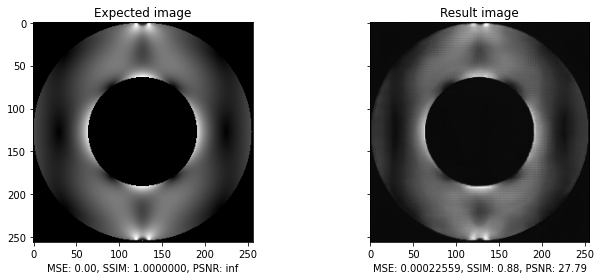

In [ ]:
metrics(get_model8(), 'Model8_100e_4b_256_2500.h5', 4)

**Predicción sobre imágenes externas**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

def predict(arq, model_url, bs, image):
  model = read_model(arq, model_url, bs)
  image = np.expand_dims(np.load('/content/drive/My Drive/Tesis/SeleccionJhonatan2/Disco/Stack1234/'+ str(image) + '.npy'), axis=0)
  image = image/255
  pred = model.predict(image, batch_size=bs)
  pred = np.reshape(pred, (256, 256))

  #Show result
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True, sharey=True)
  ax = axes.ravel()

  #Predicted image
  ax[0].imshow(np.reshape(image,(256,256,4)), cmap='gray')
  ax[0].set_title('Original image')

  #Original image
  ax[1].imshow(pred, cmap='gray')
  ax[1].set_title('Predicted image')

  plt.tight_layout()
  plt.show()

# **Anillo**

**Modelo 2**

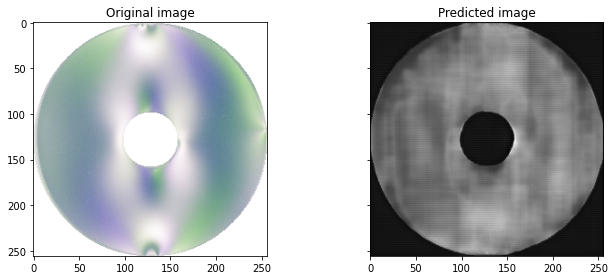

In [ ]:
predict(get_model2(), 'Model1234_2_100e_4b.h5', 4, 500)

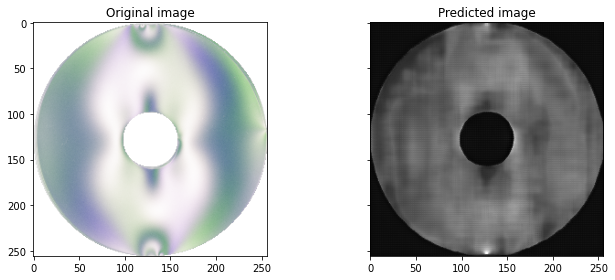

In [ ]:
predict(get_model2(), 'Model1234_2_100e_4b.h5', 4, 1000)

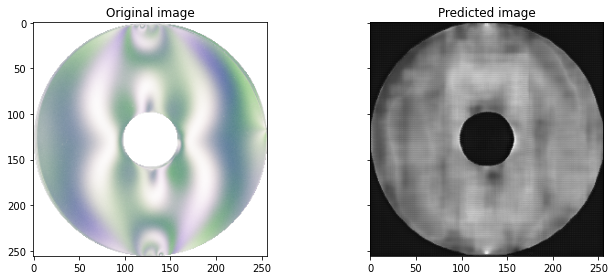

In [ ]:
predict(get_model2(), 'Model1234_2_100e_4b.h5', 4, 1500)

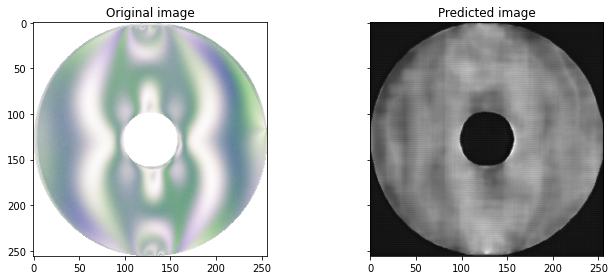

In [ ]:
predict(get_model2(), 'Model1234_2_100e_4b.h5', 4, 2000)

**Modelo 8**

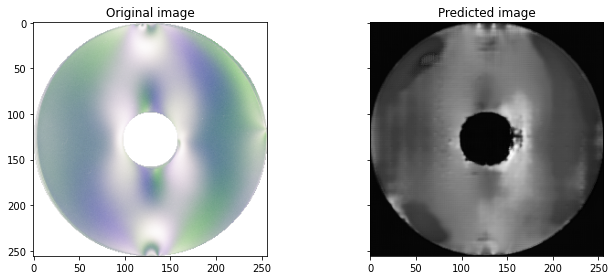

In [ ]:
predict(get_model8(), 'Model1234_8_100e_4b.h5', 4, 500)

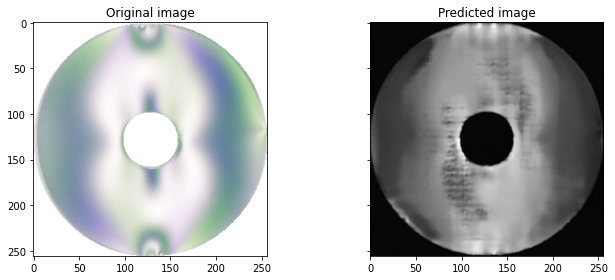

In [ ]:
predict(get_model8(), 'Model1234_8_100e_4b.h5', 4, 1000)

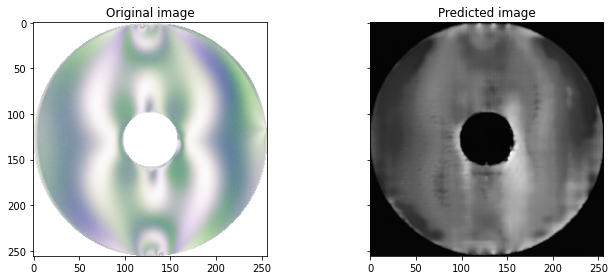

In [ ]:
predict(get_model8(), 'Model1234_8_100e_4b.h5', 4, 1500)

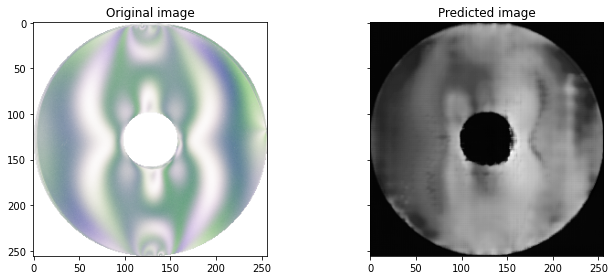

In [ ]:
predict(get_model8(), 'Model1234_8_100e_4b.h5', 4, 2000)

---

# **Disco**

**Modelo 2**

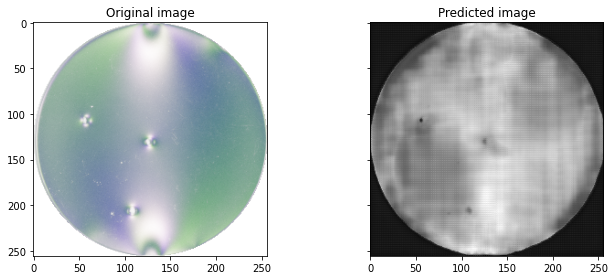

In [ ]:
predict(get_model2(), 'Model1234_2_100e_4b.h5', 4, 500)

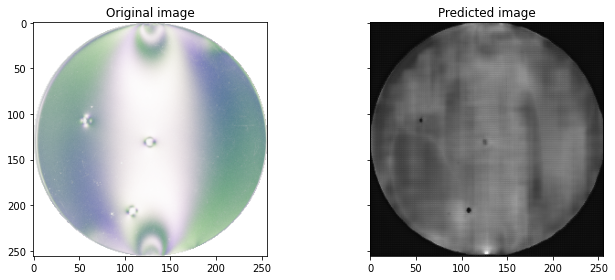

In [ ]:
predict(get_model2(), 'Model1234_2_100e_4b.h5', 4, 1000)

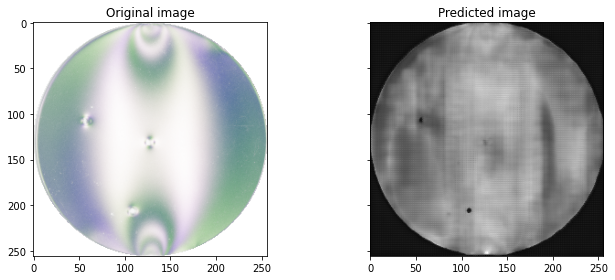

In [ ]:
predict(get_model2(), 'Model1234_2_100e_4b.h5', 4, 1500)

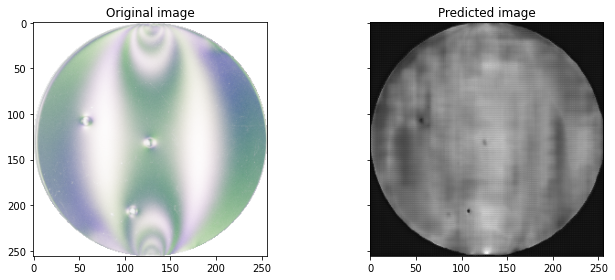

In [ ]:
predict(get_model2(), 'Model1234_2_100e_4b.h5', 4, 2000)

**Modelo 8**

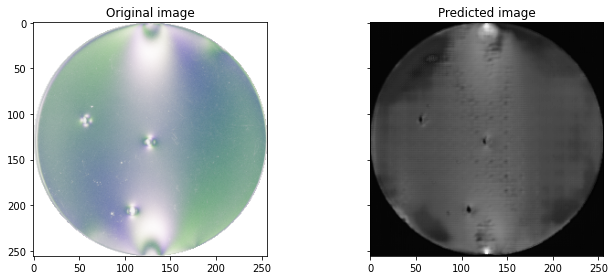

In [ ]:
predict(get_model8(), 'Model1234_8_100e_4b.h5', 4, 500)

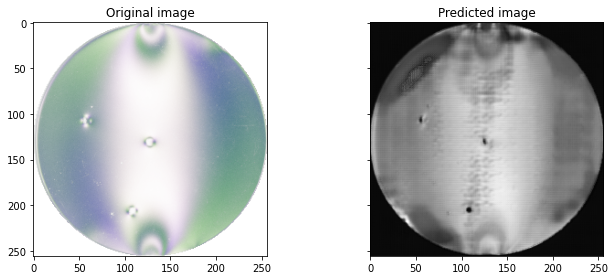

In [ ]:
predict(get_model8(), 'Model1234_8_100e_4b.h5', 4, 1000)

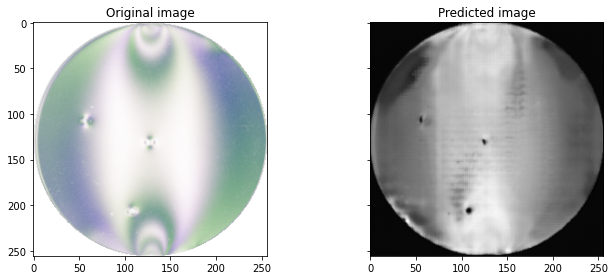

In [ ]:
predict(get_model8(), 'Model1234_8_100e_4b.h5', 4, 1500)

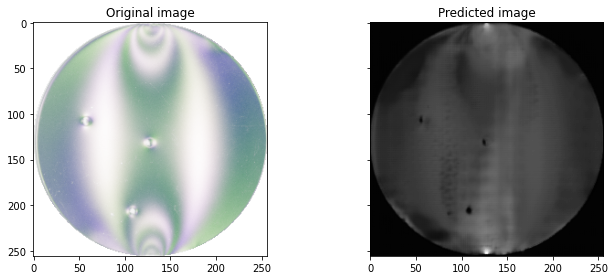

In [ ]:
predict(get_model8(), 'Model1234_8_100e_4b.h5', 4, 2000)